In [5]:
import numpy as np
import pandas as pd
from scipy import linalg
from sklearn.preprocessing import OneHotEncoder
#import emachine as EM
from direct_info import direct_info

from data_processing import data_processing
import Bio.PDB, warnings
pdb_list = Bio.PDB.PDBList()
pdb_parser = Bio.PDB.PDBParser()
from scipy.spatial import distance_matrix
from Bio import BiopythonWarning
warnings.simplefilter('ignore', BiopythonWarning)

from scipy.sparse import csr_matrix
from joblib import Parallel, delayed
import timeit

import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(1)

## We will start by reading in a set of Protein structures with the given Protein ID "pfam_id"

In [6]:
# Read in Protein structure
data_path = '../protein/Pfam-A.full'
pfam_id = 'PF00186'
pdb = np.load('%s/%s/pdb_refs.npy'%(data_path,pfam_id))

In [7]:
# delete 'b' in front of letters (python 2 --> python 3)
pdb = np.array([pdb[t,i].decode('UTF-8') for t in range(pdb.shape[0]) \
         for i in range(pdb.shape[1])]).reshape(pdb.shape[0],pdb.shape[1])

In [8]:
# Print number of pdb structures in Protein ID folder
npdb = pdb.shape[0]
print('number of pdb structures:',npdb)

('number of pdb structures:', 372)


In [9]:
# Print PDB array 
print(pdb)

[[u'PF00186' u'69' u'Q5KZ26_GEOKA' ... u'B' u'1' u'160']
 [u'PF00186' u'69' u'Q5KZ26_GEOKA' ... u'A' u'1' u'160']
 [u'PF00186' u'83' u'Q81R22_BACAN' ... u'B' u'2' u'160']
 ...
 [u'PF00186' u'6952' u'DYR_MYCTU' ... u'A' u'1' u'158']
 [u'PF00186' u'7457' u'Q834R2_ENTFA' ... u'A' u'1' u'161']
 [u'PF00186' u'7457' u'Q834R2_ENTFA' ... u'A' u'1' u'161']]


Using the array of PDB structures above we will create a pandas database for easy data manipulation

In [10]:
# Create pandas dataframe for protein structure
df = pd.DataFrame(pdb,columns = ['PF','seq','id','uniprot_start','uniprot_start',\
                                 'pdb_id','chain','pdb_start','pdb_end'])
df.head()

,PF,seq,id,uniprot_start,uniprot_start,pdb_id,chain,pdb_start,pdb_end
0,PF00186,69,Q5KZ26_GEOKA,1,160,1ZDR,B,1,160
1,PF00186,69,Q5KZ26_GEOKA,1,160,1ZDR,A,1,160
2,PF00186,83,Q81R22_BACAN,2,160,3JWK,B,2,160
3,PF00186,83,Q81R22_BACAN,2,160,3S9U,B,2,160
4,PF00186,83,Q81R22_BACAN,2,160,3FL9,H,2,160


Import contact map functions from newly defined tools python module

In [11]:
from ecc_tools import contact_map

In [12]:
ipdb = 0
print('seq:',int(pdb[ipdb,1]))

# data processing
s0,cols_removed = data_processing(data_path,pfam_id,ipdb,\
                gap_seqs=0.2,gap_cols=0.2,prob_low=0.004,conserved_cols=0.9)

ct = contact_map(pdb,ipdb,cols_removed)

('seq:', 69)


Plot the contact Map of the imported Protein structure

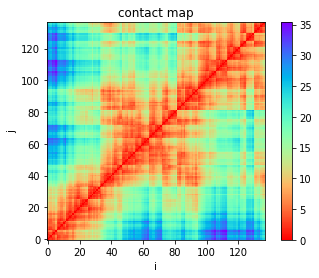

In [13]:
plt.title('contact map')
plt.imshow(ct,cmap='rainbow_r',origin='lower')
plt.xlabel('i')
plt.ylabel('j')
plt.colorbar(fraction=0.045, pad=0.05)
plt.show()

## Now we want to use Expectation Reflection to infer the "calculate the weights " 
  * Infer interactions between residues (R-part of ammino acid) in proteins from Multiple Sequence Alignment (MSA) data
  * More understanding required on meaning/interpretation of weights
  
We can start by definig some important values of our protein structures

In [14]:
# number of positions
n_var = s0.shape[1]
print("Number of residue positions:",n_var)

# number of aminoacids at each position
mx = np.array([len(np.unique(s0[:,i])) for i in range(n_var)])
#mx = np.array([m for i in range(n_var)])
print("Number of different amino acids at each position",mx)

mx_cumsum = np.insert(mx.cumsum(),0,0)
i1i2 = np.stack([mx_cumsum[:-1],mx_cumsum[1:]]).T 
print("(Sanity Check) Indices of first and (",i1i2[0],") and last (",i1i2[-1],") positions")
# number of variables
mx_sum = mx.sum()
print("Total number of variables",mx_sum)

# number of bias term
n_linear = mx_sum - n_var

('Number of residue positions:', 137)
('Number of different amino acids at each position', array([ 6, 16, 12,  7,  8, 16,  8, 17, 12, 14,  9, 19, 11, 10, 13,  5,  5,
       14,  9,  6, 11,  2,  9, 12, 11,  9, 10, 16, 17, 11, 12, 13,  5,  4,
        9,  7, 11,  6,  5, 10, 12, 10,  9,  9, 17,  8,  8,  2,  5,  2, 11,
       11, 18, 18, 20, 20, 20, 14, 13, 15, 16, 15, 14, 14,  7, 12, 15, 12,
        8, 15, 15, 21, 19, 16, 16, 20, 15, 17, 13, 11,  8, 10, 12, 13,  4,
        3, 13, 15, 12, 11, 13, 19,  9, 11, 17,  7, 14,  8, 16,  3, 16, 19,
       15, 14, 15,  7,  7, 15,  7, 17, 10, 16, 20, 17, 18,  5, 17, 16, 17,
       20, 19, 18, 21, 21, 19, 15, 17, 13, 16, 13, 14, 10, 14,  9, 18, 14,
        5]))
('(Sanity Check) Indices of first and (', array([0, 6]), ') and last (', array([1697, 1702]), ') positions')
('Total number of variables', 1702)


The above indices help to divide all the possible amino acids at different positions to binary choices which will be implemented wit 1 of K notation (OneHot Encoder)

In [15]:
onehot_encoder = OneHotEncoder(sparse=False,categories='auto')
s = onehot_encoder.fit_transform(s0)

In [16]:
mx_sum = mx.sum()
my_sum = mx.sum() #!!!! my_sum = mx_sum

w = np.zeros((mx_sum,my_sum))
h0 = np.zeros(my_sum)

### Apply Expectation Reflection
We can now apply expectation reflection to infer the connection between postion residues

In [17]:
import sys
import numpy as np
from scipy import linalg
from sklearn.preprocessing import OneHotEncoder
import expectation_reflection as ER
from direct_info import direct_info
from joblib import Parallel, delayed

In [19]:
# Expectation Reflection
#=========================================================================================
def predict_w(s,i0,i1i2,niter_max,l2):
    #print('i0:',i0)
    i1,i2 = i1i2[i0,0],i1i2[i0,1]

    x = np.hstack([s[:,:i1],s[:,i2:]])
    y = s[:,i1:i2]

    h01,w1 = ER.fit(x,y,niter_max,l2)

    return h01,w1

#-------------------------------
# parallel
start_time = timeit.default_timer()
res = Parallel(n_jobs = 32)(delayed(predict_w)\
#res = Parallel(n_jobs = 8)(delayed(predict_w)\
        (s,i0,i1i2,niter_max=10,l2=100.0)\
        for i0 in range(n_var))

run_time = timeit.default_timer() - start_time
print('run time:',run_time)
## This above line seems wrong, seems like the following for loop should be moved up?? not sure if this is some 
## python implementation or just wrong
#-------------------------------
for i0 in range(n_var):
    i1,i2 = i1i2[i0,0],i1i2[i0,1]

    h01 = res[i0][0]
    w1 = res[i0][1]

    h0[i1:i2] = h01
    w[:i1,i1:i2] = w1[:i1,:]
    w[i2:,i1:i2] = w1[i1:,:]

# make w symmetric
w = (w + w.T)/2.
di = direct_info(s0,w)
np.savetxt('%s/di.dat'%pfam_id,di,fmt='% 3.8f')


('run time:', 487.04568314552307)


IOError: [Errno 2] No such file or directory: 'PF00186/di.dat'